##### Follow the instructions from ReadMe.txt to run the ipynb files without errors

In [1]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from timeit import default_timer as timer

In [25]:
# Importing data
df = pd.read_hdf('256.h5')

/home/prabhu.v/.conda/envs/py39conda/lib/python3.9/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [34]:
df

,0,1,2,3,4,5,6,7,8,9,...,65528,65529,65530,65531,65532,65533,65534,65535,Class,Data
0,23,20,19,19,17,15,35,55,59,62,...,108,111,110,111,111,112,113,113,0,train
1,14,22,24,29,31,34,36,37,43,47,...,0,0,0,0,0,0,0,0,0,train
2,0,0,0,2,15,21,27,32,35,42,...,0,0,0,0,0,0,0,2,0,train
3,39,44,47,50,55,56,59,62,68,75,...,10,11,10,11,11,11,12,12,0,train
4,76,73,65,60,52,45,37,30,27,24,...,0,0,0,0,0,0,0,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0,0,0,6,11,18,26,30,30,29,...,1,1,2,2,2,2,2,2,1,val
4,0,0,0,2,9,12,17,23,29,39,...,2,2,2,2,2,2,2,2,1,val
5,0,0,0,0,0,0,0,0,0,0,...,124,52,70,34,10,11,9,7,1,val
6,65,66,66,65,65,64,64,64,65,67,...,2,2,3,10,8,7,10,9,1,val


In [26]:
# Checking if gpu is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [27]:
# Dividing data into training test and validation set
X_train = df[df['Data']=='train']
Y_train = np.array(X_train.Class)
X_train = X_train.drop(['Data','Class'], axis=1)
X_train = np.array(X_train)
X_train = torch.tensor(X_train)
X_train = X_train/255.0
Y_train = torch.tensor(Y_train)
train_dataset = torch.utils.data.TensorDataset(X_train,Y_train)
print(torch.min(train_dataset[:][0]), torch.max(train_dataset[:][0]))

X_val = df[df['Data']=='test']
Y_val = np.array(X_val.Class)
X_val = X_val.drop(['Data','Class'], axis=1)
X_val = np.array(X_val)
X_val = torch.tensor(X_val)
X_val = X_val/255.0
Y_val = torch.tensor(Y_val)
valid_dataset = torch.utils.data.TensorDataset(X_val,Y_val)
print(torch.min(valid_dataset[:][0]), torch.max(valid_dataset[:][0]))

X_test = df[df['Data']=='val']
Y_test = np.array(X_test.Class)
X_test = X_test.drop(['Data','Class'], axis=1)
X_test = np.array(X_test)
X_test = torch.tensor(X_test)
X_test = X_test/255.0
Y_test = torch.tensor(Y_test)
test_dataset = torch.utils.data.TensorDataset(X_test,Y_test)
print(torch.min(test_dataset[:][0]), torch.max(test_dataset[:][0]))

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [35]:
# Defining hyperparameters
batch_size = 16
num_epochs = 1000
learning_rate = 1e-5
weight_decay = 1e-5
min_delta = 1e-6
patience = 20

In [51]:
# Creating data loaders to load data in batches
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers=8)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, num_workers=8)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, num_workers=8)

In [39]:
# Creating autoencoder neural network model
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(256 * 256, 64 * 64),
            nn.ReLU(),
            nn.Linear(64 * 64, 32 * 32),
            nn.ReLU(),
            nn.Linear(32 * 32, 16 * 16)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16 * 16, 32 * 32),
            nn.ReLU(),
            nn.Linear(32 * 32, 64 * 64),
            nn.ReLU(),
            nn.Linear(64 * 64, 256 * 256),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [60]:
start = timer()

# Initializing the model
model = Autoencoder_Linear()

# Moving model to GPU if its available
if torch.cuda.is_available():
    model.to(device)

# Initializing the loss function
criterion = nn.MSELoss()

# Initializing the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay)

In [15]:
epochs = []
train_losses = []
valid_losses = []
n = 0
m = patience
min_val_loss = np.inf

# Training the autoencoder model
for e in range(num_epochs):
    train_loss = 0.0
    for img, labels in train_loader:
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        optimizer.zero_grad()
        recon = model(img)
        loss = criterion(recon,img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for img, labels in valid_loader:
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        recon = model(img)
        loss = criterion(recon,img)
        valid_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    valid_loss =  valid_loss / len(valid_loader)
    
    epochs.append(e+1)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch {e+1} \t Training Loss: {train_loss} \t Validation Loss: {valid_loss}')
    
    if min_val_loss > valid_loss:
        if min_val_loss - valid_loss >= min_delta:
            m = patience
            print(f'Validation loss decreased({min_val_loss}--->{valid_loss}) \nSaving the model')
            torch.save(model.state_dict(), 'model.pth')
        else:
            m -= 1
            print(f'Validation loss did not decrease by value greater than {min_delta} \nPatience decreased to {m}')
        min_val_loss = valid_loss
    else:
        m -= 1
        print(f'Validation loss did not decrease \nPatience decreased to {m}')
        
    if m == 0:
        print('Ran out of patience! Stopping training early.')
        break
        
    if min_val_loss == 0:
        print('Reached zero loss! Stopping training early.')
        break
        
end = timer()

Epoch 1 	 Training Loss: 0.024988498707284774 	 Validation Loss: 0.019760037605197
Validation loss decreased(inf--->0.019760037605197) 
Saving the model
Epoch 2 	 Training Loss: 0.017336008516054578 	 Validation Loss: 0.017601274288235567
Validation loss decreased(0.019760037605197--->0.017601274288235567) 
Saving the model
Epoch 3 	 Training Loss: 0.01643764807277022 	 Validation Loss: 0.016633980811979525
Validation loss decreased(0.017601274288235567--->0.016633980811979525) 
Saving the model
Epoch 4 	 Training Loss: 0.015349598467190024 	 Validation Loss: 0.015555721588241748
Validation loss decreased(0.016633980811979525--->0.015555721588241748) 
Saving the model
Epoch 5 	 Training Loss: 0.014095766641245297 	 Validation Loss: 0.014122912899041787
Validation loss decreased(0.015555721588241748--->0.014122912899041787) 
Saving the model
Epoch 6 	 Training Loss: 0.013344107101459992 	 Validation Loss: 0.01358443446075305
Validation loss decreased(0.014122912899041787--->0.0135844344

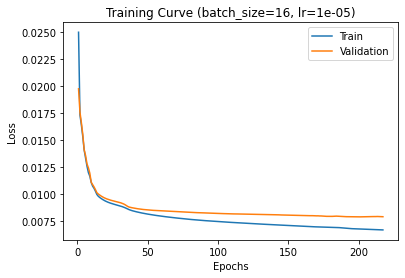

In [17]:
# Plotting training and validation loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, valid_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [61]:
model = Autoencoder_Linear()

# Importing saved model
model.load_state_dict(torch.load('model.pth'))
if torch.cuda.is_available():
    model.to(device)
model.state_dict() 

OrderedDict([('encoder.0.weight',
              tensor([[ 1.7150e-40,  1.6236e-40, -2.4574e-40,  ..., -1.0840e-40,
                        1.7353e-40, -2.5681e-40],
                      [-5.6784e-40, -5.6977e-40, -8.3023e-40,  ..., -1.3185e-40,
                       -5.0632e-40, -1.0710e-40],
                      [-6.2714e-40, -6.0960e-40, -4.9431e-40,  ..., -3.6114e-40,
                       -5.2932e-40, -5.7200e-40],
                      ...,
                      [-5.7398e-04, -5.5258e-04, -9.3303e-06,  ...,  1.3755e-04,
                        1.8811e-04,  1.1698e-05],
                      [ 4.2201e-04,  3.2687e-04, -3.5641e-05,  ..., -2.6214e-04,
                       -3.1100e-04, -3.8322e-04],
                      [-1.6493e-39, -1.7523e-39, -1.1586e-39,  ..., -5.8481e-40,
                       -4.9169e-40, -3.6712e-40]], device='cuda:0')),
             ('encoder.0.bias',
              tensor([-1.1217e-40, -1.5465e-39, -1.8786e-40,  ...,  7.2619e-03,
                     

In [52]:
# Dimensionally reducing the image data
train_enc = pd.DataFrame()
valid_enc = pd.DataFrame()
test_enc = pd.DataFrame()

with torch.no_grad():
    for img, labels in tqdm(train_loader):
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        encoded_train = model.encoder(img)
        enc_train_X = encoded_train.detach().to("cpu").numpy()
        enc_train_Y = labels.detach().to("cpu").numpy()
        df_train = pd.DataFrame(enc_train_X)
        df_train['class'] = enc_train_Y
        train_enc = pd.concat([train_enc, df_train])
        
    for img, labels in tqdm(valid_loader):
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        encoded_valid = model.encoder(img)
        enc_valid_X = encoded_valid.detach().to("cpu").numpy()
        enc_valid_Y = labels.detach().to("cpu").numpy()
        df_valid = pd.DataFrame(enc_valid_X)
        df_valid['class'] = enc_valid_Y
        valid_enc = pd.concat([valid_enc, df_valid])
        
    for img, labels in tqdm(test_loader):
        if torch.cuda.is_available():
            img, labels = img.cuda(), labels.cuda()
        encoded_test = model.encoder(img)
        enc_test_X = encoded_test.detach().to("cpu").numpy()
        enc_test_Y = labels.detach().to("cpu").numpy()
        df_test = pd.DataFrame(enc_test_X)
        df_test['class'] = enc_test_Y
        test_enc = pd.concat([test_enc, df_test])    

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


In [56]:
train_enc['data'] = 'train'
valid_enc['data'] = 'valid'
test_enc['data'] = 'test'

data_enc = pd.concat([train_enc, valid_enc, test_enc])
data_enc

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,class,data
0,26.615173,6.482534,-7.645945,-15.057341,-10.593945,-4.938653,6.341402,-5.955104,-9.404397,-4.212574,...,11.154510,-3.581766,-4.486453,-3.682867,2.774579,-9.705235,-1.249602,-14.412155,0,train
1,24.526199,-5.647734,-10.133872,-14.141376,-16.093613,-13.252722,6.050599,-9.418413,-9.958363,-7.893964,...,14.849681,-19.519867,0.171322,-14.290077,-0.153876,6.635268,1.564528,-25.917673,0,train
2,25.412903,8.252574,-10.094581,-19.510935,-18.455120,-4.730817,7.032505,-6.262510,-10.469352,-8.083861,...,17.219156,-11.539368,-2.997644,-6.447153,0.289411,-4.524711,2.169890,-22.424238,0,train
3,22.247965,7.435191,-11.686460,-16.022451,-18.848209,-5.985556,5.088256,-9.762956,-10.445632,-9.669856,...,18.702717,-15.992507,-1.173018,-9.884384,-1.597707,-0.346646,2.071992,-24.409138,0,train
4,27.895016,-5.128004,-9.386974,-14.738308,-23.153099,-12.740804,7.829080,-10.918048,-12.149691,-5.865152,...,14.642686,-19.822620,-6.296193,-16.205683,2.797771,0.511406,-0.135634,-26.831747,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,21.650343,3.577266,-10.441361,-13.017966,-15.998093,-14.245616,4.836104,-12.986773,-9.805331,-12.979307,...,14.449028,-17.052980,0.547110,-16.139853,-3.168107,7.092625,-2.112412,-26.019140,1,test
12,18.201328,-5.548238,-13.431869,-12.993523,-10.156819,-20.649433,2.420440,-14.651651,-5.326435,-16.330397,...,17.394842,-24.109447,6.464675,-19.102888,-8.584020,16.700846,-1.678842,-27.107174,1,test
13,22.814554,-13.350932,-13.665328,-14.696050,-3.495737,-11.708524,-6.425398,-9.640905,-1.275181,-5.141012,...,13.121637,-14.001936,17.860893,5.529498,-3.057990,-0.646030,1.079854,-7.364069,1,test
14,29.101109,-1.032178,-10.608701,-14.039901,1.624651,-12.629971,-8.809180,-12.112627,-4.948981,-12.458016,...,13.125866,-9.686213,17.544012,1.280483,-6.781421,3.126143,0.527616,-8.692055,1,test


In [63]:
# Saving dimensionally reduced image data
data_enc.to_hdf('256->16.h5', key='stage', mode='w', index=False)

/tmp/ipykernel_26735/3506094712.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  data_enc.to_hdf('256->16.h5', key='stage', mode='w', index=False)
/tmp/ipykernel_26735/3506094712.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block0_items] [items->None]

  data_enc.to_hdf('256->16.h5', key='stage', mode='w', index=False)
